#### *Applied Mathematical Finance 2*

## <ins> *Lab 3: Vanilla commodities* </ins>

The deadline is 23:59 on 25th of May, 2025. The solution must be sent up to the deadline on amf2-2025-spring@yandex.ru.


### 1. Composite coal swap (50 points)

You are given a composite coal swap with

* 12 observation dates $t_i$ equal to the last Friday of each calendar month of the year 2023.

* $S$ corresponding to weekly coal fixing.

* $X$ equal to the USDRUB fixing. 

* Payoff at $t_{12}$ is 

$$\frac{1}{12} \sum_{i=1}^{12} S_{t_i} X_{t_i + l} - K,$$

with $l=-2$ weeks being the FX fixing lag and $K$ the strike of the swap contract. 


Also assume that 

* The value date $t_0$ is `03/01/2023`;

* The continuously-compounded foreign-domestic rates difference $r_{\text{USD}} - r_{\text{RUB}} = 10\%$;

* The USDRUB spot and volatility equal to $100$ and $40\%$;

* The coal volatility is $50\%$ and the Coal/FX correlation is $-80\%$;

* The coal monthly average futures quotes (denominated in USD currency) are given in `lab3.csv`.

Finally, assume that the day count convention is `Act365`. 

#### 1.1 Curve stripping (25 points)

Build weekly-observable forward curve. 

In [156]:
from datetime import date
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import QuantLib as ql
from scipy.stats import norm
from scipy.interpolate import PchipInterpolator
from scipy.optimize import fsolve


In [157]:
day_count = ql.Actual365Fixed()
calendar = ql.UnitedStates(ql.UnitedStates.NYSE)  

valueDate = date(2023, 1, 3)
t0 = ql.Date(3, 1, 2023)
spread_rate = 0.1
exchange_rate_spot = 100
exchange_rate_vol = 0.4
coal_vol = 0.5
corr_coal_fx = -0.8

quanto_lag = -14 / 365


In [158]:
futures_curve = pd.read_csv("lab3.csv", sep=";")
futures_curve = futures_curve.drop(["Unnamed: 0"], axis=1)
futures_curve.columns = ["expiry", "price"]
# futures_curve["expiry"] = pd.to_datetime(futures_curve["expiry"])

In [159]:
futures_curve

,expiry,price
0,27/1/2023,230.00
1,24/2/2023,206.00
2,31/3/2023,194.90
3,28/4/2023,185.75
4,26/5/2023,174.50
5,30/6/2023,163.25
6,28/7/2023,138.70
7,25/8/2023,132.65
8,29/9/2023,129.30
9,27/10/2023,124.85


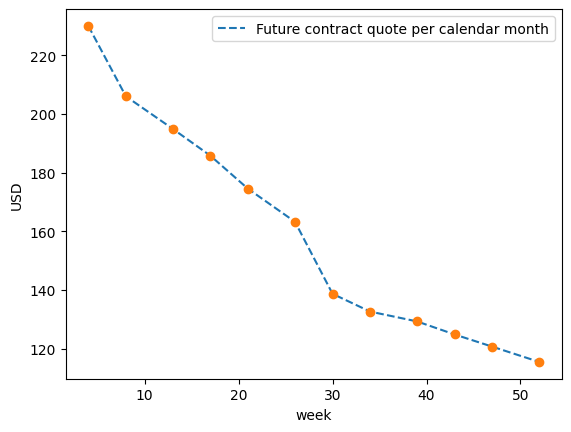

In [160]:
F = futures_curve["price"].to_numpy().astype(float)
n = np.array([4, 4, 5, 4, 4, 5, 4, 4, 5, 4, 4, 5])
N_node = np.zeros(13)
for i  in range(1,13):
  N_node[i] = N_node[i-1] + n[i-1]

plt.plot(N_node[1:], F, '--', label='Future contract quote per calendar month')
plt.plot(N_node[1:], F, 'o')
plt.xlabel("week")
plt.ylabel("USD")
plt.legend()
plt.show()

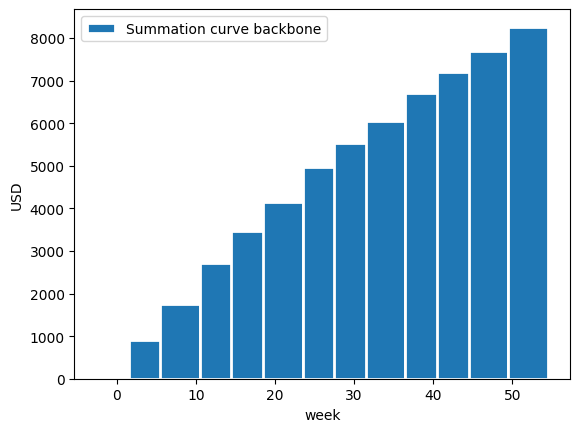

In [161]:
summation_curve_node = np.zeros(13)
for i  in range(1,13):
  summation_curve_node[i] = summation_curve_node[i-1] + F[i-1]*n[i-1]
plt.bar(N_node, summation_curve_node, width=5, edgecolor="white", linewidth=2, label='Summation curve backbone')
plt.xlabel("week")
plt.ylabel("USD")
plt.legend()
plt.show()

In [162]:
f_t = np.zeros(52)
N = np.arange(1,53)
for i in range(1,53):
  f_t[i-1] = PchipInterpolator(N_node, summation_curve_node)(i) - PchipInterpolator(N_node, summation_curve_node)(i-1)

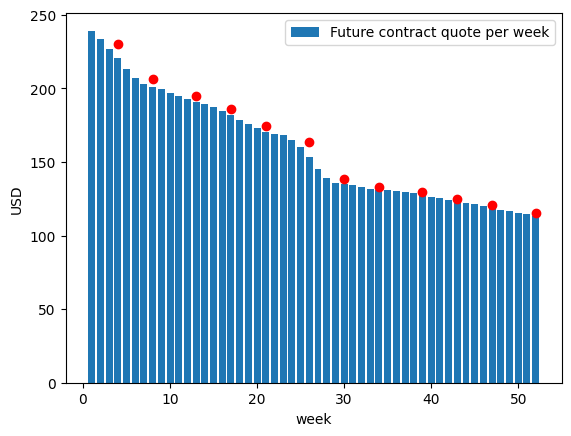

In [163]:
plt.bar(N, f_t, label='Future contract quote per week')
plt.plot(N_node[1:], F, 'o',color = 'r')
plt.xlabel("week")
plt.ylabel("USD")
# plt.ylim(141, 147)
plt.legend()
plt.show()

#### 1.2 Composite coal swap pricing (25 points)

Using standard model of correlated Brownian motions compute par strike $K$ of a composite coal swap with the specifications provided above. 

In [164]:
def quantoCompoSwapStrike(
    future_price: float,
    exchange_rate_spot: float,
    exchange_rate_vol: float,
    coal_vol: float,
    corr_coal_fx: float,
    spread_rate: float,
    spot_tenor: float
):
    return exchange_rate_spot * np.exp(spread_rate * (spot_tenor)) * future_price * np.exp(- corr_coal_fx * exchange_rate_vol * coal_vol * max(-quanto_lag, 0)) 

In [165]:
def convert_to_date(date_str):
    day, month, year = map(int, date_str.split('/'))
    return ql.Date(day, month, year)

In [166]:
dates = np.array([convert_to_date(item) for item in futures_curve["expiry"].to_list()])
dates_frac = np.array([
    day_count.yearFraction(t0, calendar.advance(t1, ql.Period(-2, ql.Weeks))) for t1 in dates
])

quanto_strike = np.array([
    quantoCompoSwapStrike(
        f_t[num - 1],
        exchange_rate_spot,
        exchange_rate_vol,
        coal_vol,
        corr_coal_fx,
        spread_rate,
        dates_frac[i]
    ) for i, num in enumerate(np.cumsum(n))
])
quanto_strike

array([22259.56136623, 20413.13545235, 19595.22706599, 18792.90050015,
       17753.96004486, 16160.97054452, 14309.36752559, 14018.34426789,
       13759.34880663, 13402.64636927, 13024.68913134, 12525.3860286 ])

In [167]:
swap_strike = np.sum(quanto_strike) / 12.
print("par strike: ", swap_strike)

par strike:  16334.628091950777


### 2. Brent vanilla option with early expiry (50 points)

You are given a European call option on BRENT_MAY_24 oil futures with expiry date `28/07/2023` and the strike $K = 70.73$. 

Assume that 

* The value date $t_0$ is `18/05/2023`;

* The BRENT_MAT_24 futures contract price is $70.73$ (that is, the option is ATM);

* The market implied volatility is $41.61\%$ and the natural option maturity is `25/03/2024`; 

* The futures contract maturity is `28/03/2024`;

* The Andersen's model parameters are $\sigma_0 = 0.5$, $\sigma_{\infty} = 0.2$, $\rho_{\infty} = 0.75$, $\kappa = 1$. Also assume that there is no seasonality in correlations, i.e. $f_{\infty}(t) = \rho_{\infty}$.

Using the Andersen's model, find the (undiscounted) price of a Europan call described above.

In [168]:
iv = 0.4161
K = 70.73
F = K
sigma_0 = 0.5
sigma_inf = 0.2
rho_inf = 0.75
f_t_inf = rho_inf
kappa = 1

futures_mat_date = ql.Date(28, 3, 2024)
option_nat_date = ql.Date(25, 3, 2024)
value_date = ql.Date(18, 5, 2023) 
futures_exp_date = ql.Date(28, 7, 2023)

In [169]:
h_inf = sigma_inf
h1 = rho_inf * sigma_0 - h_inf
h2 = np.sqrt(sigma_0**2 - (h1 + h_inf)**2)

In [170]:
q = h1*h_inf / (h1**2 + h2**2)
w = q*h_inf/h1

In [171]:
def calibrate_d(d: float):
    return (q * np.exp(d) + w)/(np.sqrt(w) * np.sqrt(np.exp(2 * d) + 2 * q * np.exp(d) + w)) - f_t_inf

def calibrate_a(
    iv: float, 
    value_date: date, 
    option_nat_date: date,
    futures_mat_date: date,
    d: float = 0
):
    first = (h1**2 + h2 ** 2) * np.exp(2 * d) * (np.exp(-2 * kappa * day_count.yearFraction(option_nat_date, futures_mat_date)) - np.exp(-2*kappa * day_count.yearFraction(value_date, futures_mat_date)))/(2 * kappa * day_count.yearFraction(value_date, option_nat_date))
    second = 2 * h1 * h_inf * np.exp(d) * (np.exp(-kappa * day_count.yearFraction(option_nat_date, futures_mat_date)) - np.exp(-kappa * day_count.yearFraction(value_date, futures_mat_date)))/( kappa * day_count.yearFraction(value_date, option_nat_date)) 
 
    return np.log(iv**2/(first + second + h_inf**2))/2 

In [172]:
d = fsolve(calibrate_d, 0)[0]
d

np.float64(-3.1720658386701825e-16)

In [173]:
a = calibrate_a(iv, value_date, option_nat_date, futures_mat_date)
a

np.float64(0.06296792015020447)

In [174]:
def Black(
    S: float, 
    K: float, 
    T: float, 
    r: float, 
    sigma: float
):
    d1 = (np.log(S/K) + (r + sigma**2/2)*T) / (sigma*np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    return S * norm.cdf(d1) - K *  norm.cdf(d2)

In [175]:
first = (h1**2 + h2 ** 2) * np.exp(2 * d) * (np.exp(-2 * kappa * day_count.yearFraction(futures_exp_date, futures_mat_date)) - np.exp(-2*kappa * day_count.yearFraction(value_date, futures_mat_date)))/(2 * kappa * day_count.yearFraction(value_date, futures_exp_date))
second = 2 * h1 * h_inf * np.exp(d) * (np.exp(-kappa * day_count.yearFraction(futures_exp_date, futures_mat_date)) - np.exp(-kappa * day_count.yearFraction(value_date, futures_mat_date)))/( kappa * day_count.yearFraction(value_date, futures_exp_date)) 
sigma_term = np.sqrt(first + second + h_inf**2) * np.exp(a)
sigma_term

np.float64(0.34189546309789787)

In [176]:
print("Undiscounted option price: ", Black(F, K, day_count.yearFraction(value_date, futures_exp_date), 0, sigma_term))

Undiscounted option price:  4.250876640431869
